# Introduction


- CPSC 310, Spring 2019
- Names: Reid Whitson and Luc Latiolait

## Task

Our goal for this project is to create a program which will closely guess how many points per game a first round pick will have in the NBA. To achieve this goal, we will first gather data, then we will explore some classifiers and lastly we will compare our algorithm versus whichever sci-kit learn classifier did best and compare the answers. We found that KNN was the best classifier for the data and therefore have implemented our own classifier at the end to compare how they worked.

## Data Analysis

The data set we had were players with their NBA stats; to find the corresponding First Round picks stats we had to search the players one by one and append them onto the set. This combined with the importance of the data lessens every year, we chose to focus on a smaller data set. 

The attributes that we chose as important attributes were
1. The pick they were chosen at
1. Minutes played
1. Field Goals
1. Field Goal Percentage
1. Three Points
1. Three Point Percentage
1. Free Throws
1. Points
1. Strength of Schedule

In [1]:
import operator
import random
import math
import numpy as np
import utils

def get_table(filename):
    table = []
    infile = open(filename)
    lines = infile.readlines()
    
    i = 0
    for line in lines:
        add_it = True
        line = line.strip()
        line = line.strip('\n')
        values = line.split(",")
       
        #this is only grabbing columns that are completely filled in
        if len(values) > 27:        
            for val in values:
                #Get rid of columns with NA in them
                if val == 'NA':
                    add_it = False
            if add_it:     
                #player - 6
                #pick - 4
                #MP - 31
                #FG - 32
                #FG% - 34
                #3p - 38
                #3pt% - 40
                #FT - 41
                #PTS - 52
                #SOS - 54
                #NBA PTS - 15
                
                to_add = []
                to_add.append(values[6])
                to_add.append(values[4])
                to_add.append(values[31])
                to_add.append(values[32])
                to_add.append(values[34])
                to_add.append(values[38])
                if values[40] == '':
                    to_add.append(0.0)
                else:
                    to_add.append(values[40])
                to_add.append(values[41])
                to_add.append(values[52])
                to_add.append(values[54])
                to_add.append(values[15])
                utils.convert_to_numeric(to_add)
                table.append(to_add)
    infile.close()
    return table



# Exploratory Analysis of the Data Set

The first step we took in working with our data set was to analyze the distribution of our attributes. As shown by the graphs below, the most of the attributes have a normal distribution, but some do not. For some of the attributes this outcome should be expected, like pick number, which should be evenly distributed, however, minutes played and 3 pointers per game stand out as unexpectedly abnormal. One expanation for the way minutes played clusters to the right could be that that there is a maximum limit (40 minutes) that players can reach per game. As for the 3 pointers per game graph, there seems to be two peaks in the histogram, which could indicate that there are two distributions of players, those that attempt many 3s per game (shooters), and those that do not (non-shootes). Also, NBA points per game seems to cluster to the left, which is understandable, given that even players drafted in the first round often never play in the NBA or play very little.

<IPython.core.display.Javascript object>


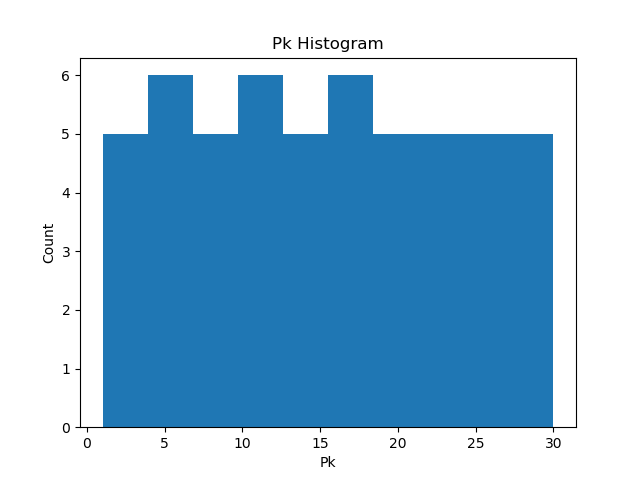

<IPython.core.display.Javascript object>


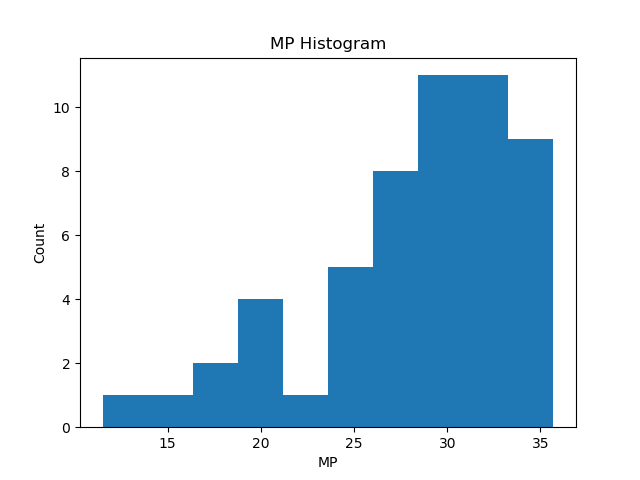

<IPython.core.display.Javascript object>


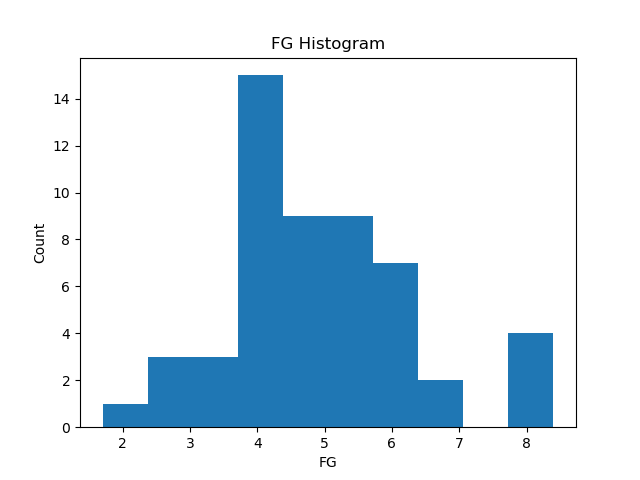

<IPython.core.display.Javascript object>


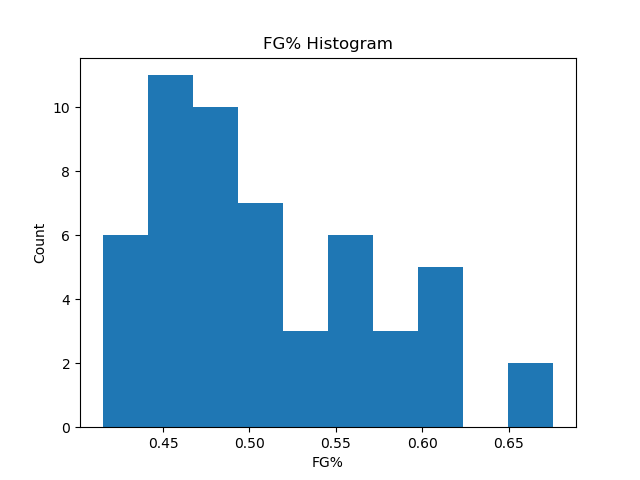

<IPython.core.display.Javascript object>


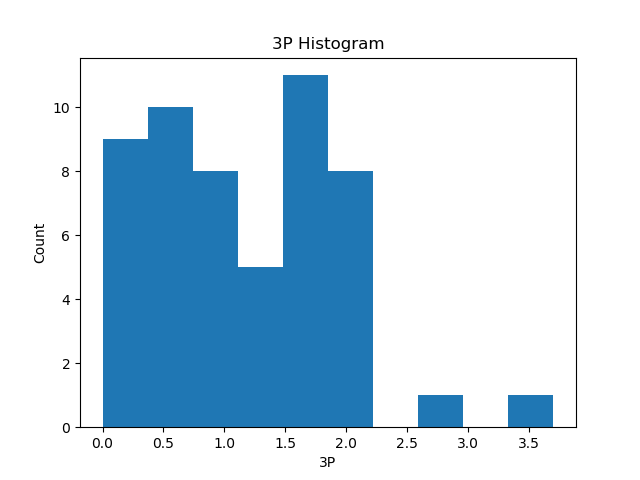

<IPython.core.display.Javascript object>


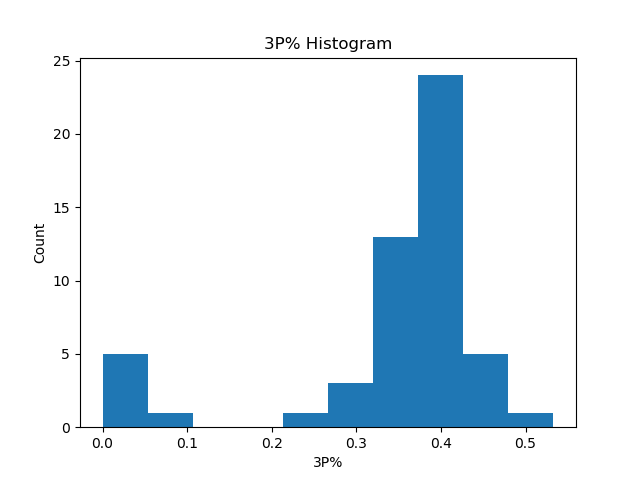

<IPython.core.display.Javascript object>


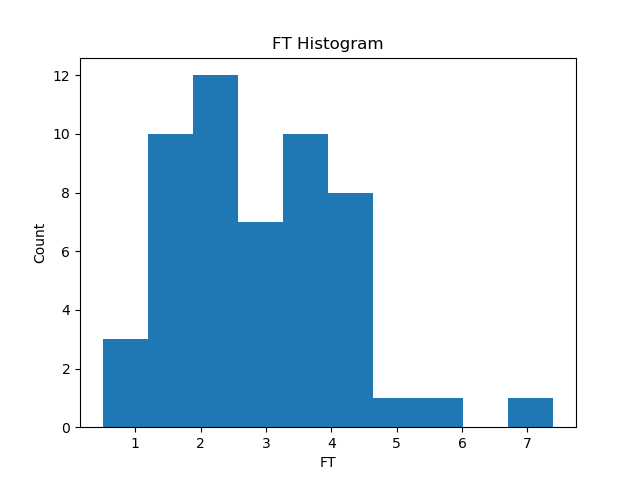

<IPython.core.display.Javascript object>


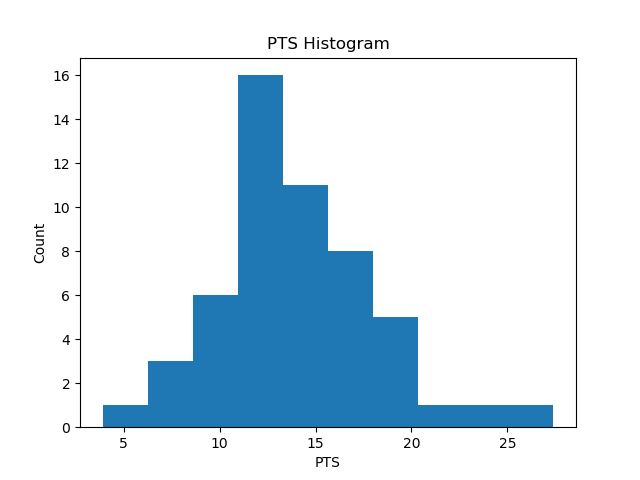

<IPython.core.display.Javascript object>


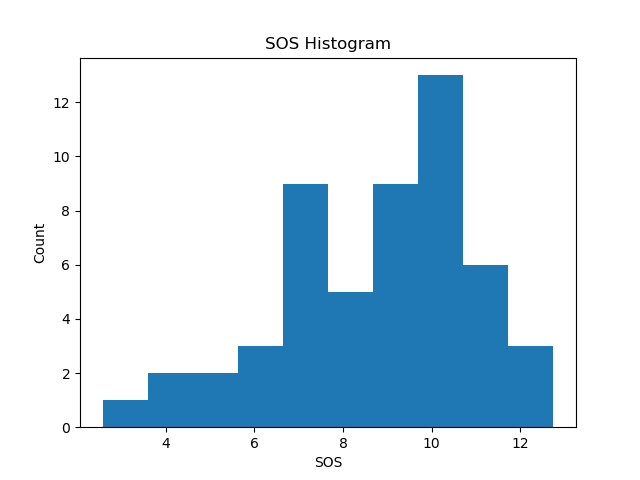

<IPython.core.display.Javascript object>


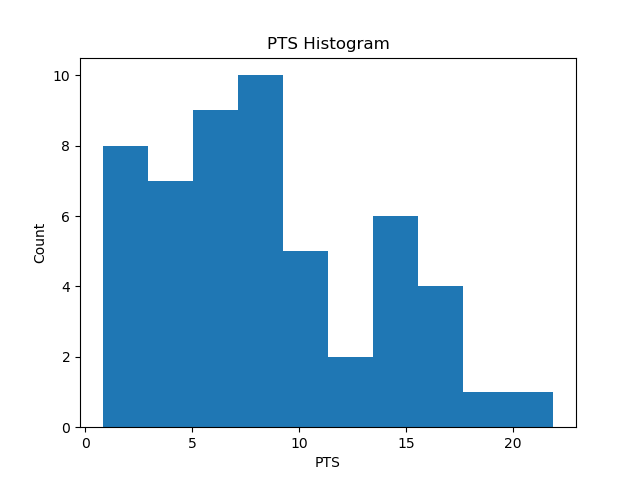

In [17]:
%matplotlib notebook
import operator
import random
import math
import numpy as np
import utils
import matplotlib.pyplot as plt 

def attribute_histograms(table, headers):
    for i in range(1, len(headers)):
        col = utils.get_column(table, i)
        header = headers[i]
        show_histogram(col, header)
        
def show_histogram(column, header):
    '''
    makes a histogram using the passed in data
    '''
    fig = plt.figure()
    plt.hist(column)
    plt.xlabel(header)
    plt.ylabel("Count")
    plt.title( header +' Histogram')
    plt.show
    #plt.close(fig)
    
start_table = get_table('datasets/firstRoundPicks_withCollegeStats.csv')
headers = start_table[0]
table = start_table[1:]
attribute_histograms(table, headers)
    

# Exploratory Classifiers

Here we do the exploratory process of looking at different learners and how they perform. We used KNN, linear regression and then Naive Bayes. For Naive Bayes we had to discretize the amount of points, 0-5, 5-10, 10-15, 15-20 and greater than 20. Therefore, the amount that that it is off is by its classification and not complete points. 

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.cluster import KMeans
from sklearn.naive_bayes import GaussianNB

start_table = get_table('datasets/firstRoundPicks_withCollegeStats.csv')
headers = start_table[0]
table = start_table[1:]
ensemble_size = 6

list_of_ind = [i for i in range(1,10)]
player_pred_knn = [0 for _ in range(len(table))]
player_pred_lin = [0 for _ in range(len(table))]
player_pred_NB = [0 for _ in range(len(table))]
Y = [row[10] for row in table]
Y_d = []

for row in table:
    if row[10] < 5:
        Y_d.append(1)
    elif row[10] < 10:
        Y_d.append(2)
    elif row[10] < 15:
        Y_d.append(3)
    elif row[10] < 20:
        Y_d.append(4)
    else:
        Y_d.append(5)

for _ in range(ensemble_size):
    X = []
    #randomly generate 4 numbers to be included
    attributes = list_of_ind
    random.shuffle(attributes)
    attributes = attributes[:4]

    for row in table:
        inter = []
        for i in attributes:
            inter.append(row[i])
        X.append(inter)

    #knn model
    n = KNeighborsRegressor(n_neighbors=5)
    n.fit(X,Y)
    
    #linear-reg model
    l = LinearRegression().fit(X,Y)
    
    #Gaussian Naive Bayes
    g = GaussianNB()
    g.fit(X,Y_d)
    
    for i, player in enumerate(table):
        rows_to_analyze = [player[a] for a in attributes]
        player_pred_knn[i] += (n.predict([rows_to_analyze]))[0]
        player_pred_lin[i] += (l.predict([rows_to_analyze]))[0]
        player_pred_NB[i] += (g.predict([rows_to_analyze]))[0]

final_pred_knn = [pred / ensemble_size for pred in player_pred_knn]
final_pred_lin = [pred / ensemble_size for pred in player_pred_lin]
final_pred_NB = [pred / ensemble_size for pred in player_pred_NB]

total_error_knn = 0
total_error_lin = 0
total_error_NB = 0

for i,player in enumerate(table):
    #uncomment if you want to see each player
    #print("Player -> " , player[0])
    #print("Guessed PPG " , final_pred[i])
    #print("Actual PPG " , player[10])
    #print()
    total_error_knn += abs(final_pred_knn[i] - player[10])
    total_error_lin += abs(final_pred_lin[i] - player[10])
    #total_error_NB += abs(final_pred_NB[i] - player[10])
    total_error_NB += abs(final_pred_NB[i] - Y_d[10])

print("---------------------------------")
print("Total points off for sci-kit learn-KNN: %.2f" % (total_error_knn / len(table)))
print("Total points off for sci-kit learn-LinReg: %.2f" % (total_error_lin / len(table)))
print("Total points off for sci-kit learn-NB: %.2f" % (total_error_NB / len(table)))


---------------------------------
Total points off for sci-kit learn-KNN: 2.96
Total points off for sci-kit learn-LinReg: 3.26
Total points off for sci-kit learn-NB: 0.81


The above answer for Naive Bayes is based on classifications 1 to 5 which are on a 5 point difference. Given being off by 0.75, that is not what we are looking for given the larger baskets of 5 points.

# Home-Made KNN function


In the knn_guess function we take in the training set and the test set and find its nearest neighbors, compute the avg points of the nearest neighbors and returns that value.

In [7]:
def knn_guess(train_set, test_set, k_val):
    '''
    classifier using knn given a test set, train set and k value
    '''
    
    init_len = len(train_set)
    init_row_len = len(train_set[0])
    
    right = 0
    wrong = 0

    for row in train_set:
        row.append(utils.compute_distances(row, test_set, train_set))  

    k = k_val
    
    length_of_rows = len(train_set[0])
    train_set.sort(key=operator.itemgetter(length_of_rows-1))

    top_k = train_set[:k]

    # calculate the averages from the nearest neighbors
    sum_ppg = 0
    for player in top_k:
        sum_ppg += player[init_row_len-1]
    avg_ppg = sum_ppg/len(top_k)

    for row in train_set:
        row.pop()
    
    return avg_ppg

Here is a the knn function that runs over the adds them to a list to be computed. After we get the guess, we then compute the average error and median and add it to a list.

In [8]:
def knnPrediction(table, headers, avg_error, median_error):    
    folds = utils.k_fold(table)
    differences = []
    for i in range(len(folds)):
        train_set = []

        for x in folds:
            if x != folds[i]:
                for item in x:
                    train_set.append(item)
        for j in folds[i]:
            my_guess = knn_guess(train_set, j, 10)
            #uncomment below to see the specific predicted points per game vs actual NBA points
            #print ("NBA PPG: " + str(j[-1]))
            #print ("predicted PPG: " + str(my_guess))
            diff = j[-1] - my_guess
            differences.append(abs(diff))

    avg_error.append(np.mean(differences))
    median_error.append(np.median(differences))
            

First we ran our kNN functions with all 9 attributes to test its effectiveness. In order to reduce the effects of random k-fold cross validation.

In [16]:
start_table = get_table('datasets/firstRoundPicks_withCollegeStats.csv')
headers = start_table[0]
table = start_table[1:]

avg_error = []
median_error = []

for _ in range(10):
    knnPrediction(table, headers, avg_error, median_error)
    
total_avg_error = sum(avg_error) / len(avg_error)
total_median_error = sum(median_error) / len(median_error)

print("---------SELF MADE KNN----------")
print("Average error : %.2f" % total_avg_error)
print("Median error : %.2f" % total_median_error)

---------SELF MADE KNN----------
Average error : 3.69
Median error : 3.23


Here we randomly generate the attributes to include, and then run the predictor over it. We keep track of the error and the median and print our the errors.

In [14]:
#fxn that calls KNN-self-done

start_table = get_table('datasets/firstRoundPicks_withCollegeStats.csv')
headers = start_table[0]
table = start_table[1:]

ensemble_size = 6

list_of_ind = [i for i in range(1,10)]

avg_error = []
median_error = []

for _ in range(ensemble_size):
    X = []
    attributes = list_of_ind
    random.shuffle(attributes)
    attributes = attributes[:4]

    for row in table:
        inter = []
        for i in attributes:
            inter.append(row[i])
        inter.append(row[-1])
        X.append(inter)
    
    knnPrediction(X, headers, avg_error, median_error)

total_avg_error = sum(avg_error) / len(avg_error)
total_median_error = sum(median_error) / len(median_error)

print("---------SELF MADE ENSEMBLE KNN----------")
print("Average error : %.2f" % total_avg_error)
print("Median error : %.2f" % total_median_error)

---------SELF MADE ENSEMBLE KNN----------
Average error : 3.92
Median error : 3.32


### Function for Correlation Coefficients

In [18]:
def find_stat_correlation_to_NBA_PTS(table, headers):
    NBA_PTS = utils.get_column(table, 10)
    for i in range(1, len(headers)-1):
        cur_column = utils.get_column(table, i)
        vals = np.corrcoef(cur_column, NBA_PTS)
        r = str(vals[0][-1])
        print (headers[i] + " correlation coefficent = " + r)

find_stat_correlation_to_NBA_PTS(table, headers)

Pk correlation coefficent = -0.5273993822093086
MP correlation coefficent = 0.21762848137756619
FG correlation coefficent = 0.36933962519403424
FG% correlation coefficent = -0.1449147250609018
3P correlation coefficent = 0.16441215828431333
3P% correlation coefficent = -0.046193036818175305
FT correlation coefficent = 0.5101851304616711
PTS correlation coefficent = 0.44179743881307093
SOS correlation coefficent = 0.1796059783207265


## Classification Results

We measured the performace of our classifiers with averages erroran, average of the absolute value of the difference between the predicted NBA points per game of a player and their actual NBA points per game. According to this measure, our best classifier was the sci-kit learn kNN classifier, with an average error of 2.96 ppg. The rest of the classifiers we used had fairly similar performance with the sci-kit learn regression classifier having an avergage error of 3.26 ppg, our self made kNN returning an average error of 3.69 ppg, and our self made ensemble kNN outputting an average error of 3.92 ppg. In assessing our self made kNN classifiers, it appears that they struggled to make accurate predictions for outliers, because both have much better median error than average error. In addition, our kNN predictor with all 9 attributes performed meaningfully better than our ensemble predictor despite the inclusion of several noisey attributes. This is likely because our ensemble kNN classifier selects attributes randomly, likely increasing the effects of noisey attributes when they are selected. Overall, all of our classifiers performed better than expected given the large amount of varience in our data set. Any classifier that can consistently predict the scoring output of an NBA prospect within a range of 3 to 4 ppg is a very useful tool for draft analysts and scouts.

# Conclusion


Through our exploration of classifiers and comparison with sci-kit learn we found that KNN is the best, and that the sci-kit learn was about a point closer on average.The hardest part of this project was dealing with finding and cleaning the data, this was due to the fact that the data for college stats wasn't easily available so we had to go one at a time. There was also some cases when college stats didn't make sense (such as players coming from Europe) which we had to clean out of our data set. I believe that KNN was a good approach to this problem due to the fact of looking at players that are similar usually provides decent results. For ways to help with performance, we could looked a little bit more specifically at the correlation coefficient and chosen ones that only showed good correlation. The ones that didn't we could get rid of. 